In [1]:
import imutils
import cv2

import os
import pandas as pd
import numpy

from sklearn.cluster import KMeans
#from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
 

folder = "test/" #input/output folder

df = pd.DataFrame(columns=['Name', 'Size', 'Contour', 'Color R', 'Color G', 'Color B'])

In [2]:
# Function to get features from each image file
#print(os.listdir())
for count, filename in enumerate(os.listdir(folder)):
    #print(filename) 
    
    # verify filetype
    name, ext = os.path.splitext(filename)
    if ext == ".jpg" or ext == ".png":

        inp = folder + filename
        dst = folder + "z_" + filename
        src = folder + filename 

        size = os.path.getsize(folder + filename)
        #print(size)

        # load the input image from disk
        image = cv2.imread(inp)

        # Find an average color
        #avg_color1 = image.mean(axis=0).mean(axis=0)
        #print(avg_color1)
        avg_color_per_row = numpy.average(image, axis=0)
        avg_color = numpy.average(avg_color_per_row, axis=0)
        #print(avg_color)

        # Convert the image to grayscale, blur it, and threshold it
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (1,1), 0)
        thresh = cv2.threshold(blurred, 120, 255, cv2.THRESH_BINARY)[1]

        # Extract contours from the image
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        #print(len(cnts))

        # loop over the contours and draw them on the input image
        #for c in cnts:
        #    cv2.drawContours(image, [c], -1, (0, 0, 255), 2)

        # Write the output image to disk
        #cv2.imwrite(dst, image)

        # Append values to dataframe
        df = df.append(dict(zip(df.columns,[filename, size, len(cnts), avg_color[0],avg_color[1],avg_color[2]])), ignore_index=True)

In [3]:
# Strings to numeric
df["Contour"] = pd.to_numeric(df["Contour"])
df["Size"]= pd.to_numeric(df["Size"])
df.describe()

,Size,Contour,Color R,Color G,Color B
count,46.000000,46.000000,46.000000,46.000000,46.000000
mean,159647.217391,1722.000000,112.184654,113.197714,119.934952
std,57986.431724,917.635948,20.577337,20.561982,24.861989
min,12442.000000,1.000000,64.774496,59.785642,59.581181
25%,118105.250000,1220.500000,94.057022,97.344315,101.351849
50%,190538.500000,1735.000000,119.773310,121.921728,129.964101
75%,206256.250000,2337.000000,128.474892,128.157109,135.988388
max,220012.000000,3296.000000,150.984711,147.194569,175.530443


In [4]:
# Normalization [0,1]
scaler = MinMaxScaler()
df0 = scaler.fit_transform(df[['Size', 'Contour', 'Color R', 'Color G', 'Color B']])
df1 = pd.DataFrame(df0, columns = ['Size', 'Contour', 'Color R', 'Color G', 'Color B'])
df1.describe()

,Size,Contour,Color R,Color G,Color B
count,46.000000,46.000000,46.000000,46.000000,46.000000
mean,0.709183,0.522307,0.549937,0.611060,0.520519
std,0.279358,0.278493,0.238688,0.235239,0.214421
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.509049,0.370106,0.339664,0.429689,0.360250
50%,0.858007,0.526252,0.637962,0.710867,0.607015
75%,0.933730,0.708953,0.738896,0.782202,0.658971
max,1.000000,1.000000,1.000000,1.000000,1.000000


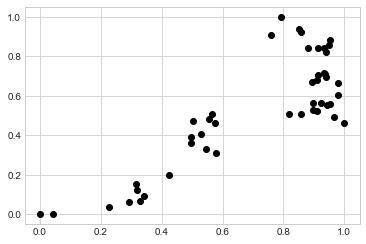

In [5]:
# Plot example
plt.plot(df1["Size"],df1["Contour"], 'o', color='black')

In [6]:
# Run clustering algorithm
k=4
ni=20
kmeans = KMeans(n_clusters=k, n_init=ni).fit(df1)
#kmeans = DBSCAN(eps=0.8, min_samples=5).fit(df1)
print(kmeans.labels_)
# Centroids to represent
centers0 = kmeans.cluster_centers_
centers = scaler.inverse_transform(centers0)

[1 1 1 1 1 1 3 0 0 0 1 2 1 2 2 1 1 1 3 0 0 1 2 2 2 2 2 2 1 0 3 0 1 1 1 1 1
 1 0 1 1 1 1 0 1 1]


In [7]:
# Add 'y' column with clustering classification
df['y'] = kmeans.labels_ 
df.describe()

,Size,Contour,Color R,Color G,Color B,y
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,159647.217391,1722.000000,112.184654,113.197714,119.934952,1.130435
std,57986.431724,917.635948,20.577337,20.561982,24.861989,0.805776
min,12442.000000,1.000000,64.774496,59.785642,59.581181,0.000000
25%,118105.250000,1220.500000,94.057022,97.344315,101.351849,1.000000
50%,190538.500000,1735.000000,119.773310,121.921728,129.964101,1.000000
75%,206256.250000,2337.000000,128.474892,128.157109,135.988388,1.750000
max,220012.000000,3296.000000,150.984711,147.194569,175.530443,3.000000


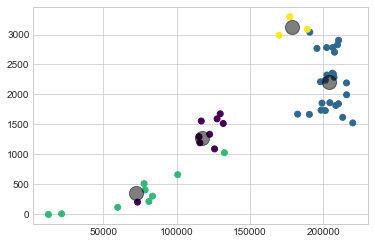

In [8]:
# Plot example with clustering colours and centroids
plt.scatter(df["Size"],df["Contour"], c=df['y'], cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [9]:
# Save output file
fname = folder + "out_cluster_res.csv"
df.to_csv(fname)